# Определение возраста покупателей

## Описание проекта

К нам обратился сетевой супермаркет «Хлеб-Соль», который хочет внедрить у себя новую технологию распознования возраста своих покупателей. Это должно помочь анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы и контролировать добросовестность кассиров при продаже алкоголя. По предоставленным данным нам нужно будет построить модель, решающую данную задачу.

## Описание данных

В нашем распоряжении одна папка со всеми изображениями - final_files и CSV-файл labels.csv с двумя колонками: file_name и real_age.

## Задача проекта

Создать нейросеть, на вход которой будет дана фотография покупателя, а на выходе она определит его точный возраст. В этом нам помогут данные, которые предоставила компания

## Импорт библиотек

In [1]:
import os
import pandas as pd
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

## Загрузка данных

Посмотрим на данные, которые нам предоставила компания

In [2]:
labels_df = pd.read_csv('/datasets/faces/labels.csv')
display(labels_df.head())
print(labels_df.shape)  
print()


img = Image.open('/datasets/faces/final_files/000000.jpg')
print(img.size)
print()

data_generator = ImageDataGenerator().flow_from_dataframe(
    dataframe=labels_df,
    directory='/datasets/faces/final_files',
    x_col='file_name',
    y_col='real_age',
    target_size=(img.size),
    batch_size=32, 
    class_mode='raw'
)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


(7591, 2)

(114, 114)

Found 7591 validated image filenames.


В labels_df два столбца(с названием картинки и реальным возрастом человека), как и должно быть. 7591 изображений хранятся в csv файле и папке. Это хорошо.  
Можно обратить внимание, что есть фотографии, которые немного повернуты от вертикали и данных не слишком много, поэтому можно будет добавить датасет с такими же фотографиями, но только повернутые

# Исследовательский анализ данных

На данном шаге подробнее окунемся в наши данные, так как нужно знать, что мы будем обучать. Для этого посмотрим на несколько изображений и проанализируем возраст покупателей

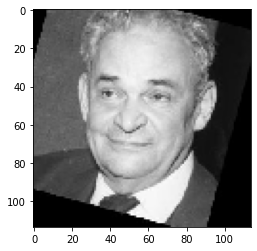

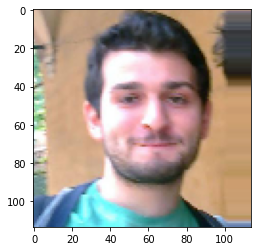

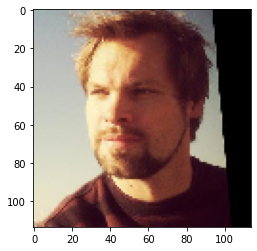

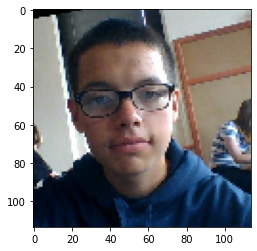

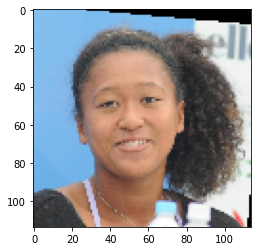

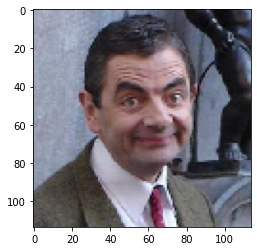

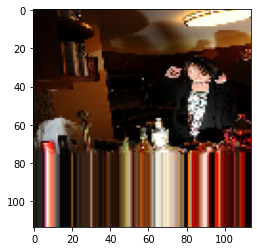

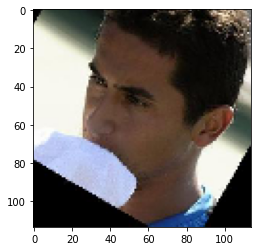

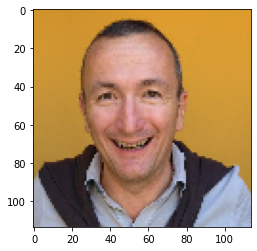

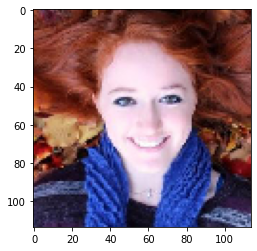

In [3]:
batch = next(data_generator)

images = batch[0][:10]

for i in range(10):
    plt.imshow(images[i].astype('uint8'))
    plt.show()

По 10 картинкам можно понять, что фотографии очень разнообразные. Где-то лица людей хорошо видно, а где-то и не очень. По краям бывают небольшие вырези, но это не страшно.  
Проверим, как вообще распределен рост покупателей.

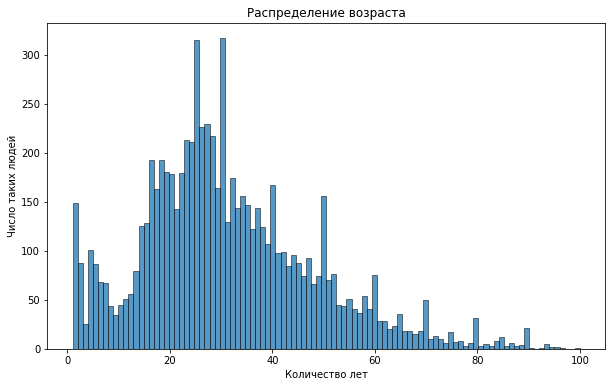

In [4]:
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.histplot(data=labels_df, x='real_age', common_norm=False, bins = 100)
plt.title('Распределение возраста')
plt.xlabel('Количество лет')
plt.ylabel('Число таких людей')
plt.show()

Больше всего график похож на биноминальное распределение. Основной пик приходится на людей от 15 до 40 лет, что в целом логично. Немного выделяется возраст близкий к 0, видимо это из-за того, что мамы не могут оставить своих детей дома и идут с ними в магазин

На этом можно завершить наш анализ данных. Мы имеем 7591 кол-во данных. Вывели некоторые изображения, чтобы убедиться, что на них есть лица, по которым можно будет определить возраст клиентов. Проверили, как распределен возраст нашего датасета, чтобы не было пробелов у модели при тестировании.  
По нашим данным можно сказать, что нейросети будет достаточно сложно обучиться, так как все фотографии очень разные, на некоторых изображениях плохо или не полностью видно лицо человека, а это самый важный фактор. Распределение возраста на обучающей выборке должно быть достаточно хорошим, так как есть все возраста и большая часть приходится на середину, как и должно быть

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import pandas as pd

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
    
    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
    
    return test_datagen_flow
    
    
def create_model(input_shape):
    backbone = ResNet50(input_shape=(150, 150, 3),
                             include_top=False,
                           weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=6, steps_per_epoch=None, validation_steps=None):
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    return model 



```

```
Train for 356 steps, validate for 119 steps
Epoch 1/5
2024-05-01 11:13:53.503014: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-05-01 11:13:54.529997: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 63s - loss: 239.0131 - mean_absolute_error: 11.2497 - val_loss: 985.9946 - val_mean_absolute_error: 26.6718
Epoch 2/5
356/356 - 37s - loss: 68.2402 - mean_absolute_error: 6.3132 - val_loss: 148.8804 - val_mean_absolute_error: 8.9929
Epoch 3/5
356/356 - 36s - loss: 37.8667 - mean_absolute_error: 4.7720 - val_loss: 108.4018 - val_mean_absolute_error: 7.8482
Epoch 4/5
356/356 - 36s - loss: 23.1642 - mean_absolute_error: 3.7381 - val_loss: 75.1778 - val_mean_absolute_error: 6.5345
Epoch 5/5
356/356 - 36s - loss: 16.4281 - mean_absolute_error: 3.1222 - val_loss: 73.9362 - val_mean_absolute_error: 6.5017
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 9s - loss: 73.9362 - mean_absolute_error: 6.5017
Test MAE: 6.5017

```

## Анализ обученной модели

У нас получилась отличная нейросеть, которая может по картинкам лица людей угадывать их возраст свозможной небольшой ошибкой в 6-7 лет. Для этого мы проделали небольшой путь, который включает в себя парочку важных этапов:  
* Загрузка данных. На данном шаге мы узнали, как выглядят таблица даных и сколько изображений нам предоставили.  
* Анализ данных. Вывели некоторые изображения, чтобы убедиться, что на них есть лица, по которым можно будет определить возраст клиентов. Проверили, как распределен возраст нашего датасета, чтобы не было пробелов у модели при тестировании.

При проверке модели мы использовали метрику MAE. Она получилась у нас равна 6.5 на тестовой выборке. На основе сверточной нейросети ResNet50, состоящей из 50 слоев строили новую последовательную модель (Sequential), к которой были добавлены слои глобального пулинга (GlobalAveragePooling2D) и полносвязный слой (Dense) с функцией активации ReLU. Размер фотографий был взят 150 на 150, батчи брали размером 16, class_mode был равен 'raw'. В оптимизаторе Adam сделали lr точнее до 0.0001  И для такого результата хватило всего 5 эпох